# Contemporary and Classical Machine Learning with Sensor Data

Machine Learning is a key component for the predictability of failures of equipment using raw sensor data in manufacturing organizations.  Performing preventative maintenance at the right time is time and cost savings to any manufacturer.  
Having equipment break down due to a faulty component is costly, and according to Aberdeen Reseach it can cost a company as much as 260,000 dollars per hour. 

And according to machinemetrics.com, for most manufacturers, downtime is the single largest source of lost production time. A new study sponsored by ServiceMax (conducted by Vanson Bourne of GE Digital), “After The Fall: Cost, Causes and Consequences of Unplanned Downtime,” surveyed 450 field service and IT decision makers across the Globe and in many industries including, manufacturing, medical, oil and gas, energy and utilities, and transportation. The study found that productivity, IT, and customer service are still hit hardest by unplanned downtime, and that the reverberation is felt across businesses as a whole.

The purpose of this project is to be able to identify machinery with faulty components which will allow for planned maintenance vs. unscheduled maintenance.  There are main approaches which will be undertaken in the project.  The classical methods using the Fast Fourier Transform and the Discrete Wavelet Transform are commonly used today.  Features are generated using these methods which becomes input to classification models such as Random Forests, Gradient Boosting, Extreme Gradient Boosting, Knn and SVM machine learnign classifiers.  The contemporary method is using one-dimensional Convolutional Neural Networks (1D-CNN).  1D-CNN's input is the raw signals from the sensor.  No need to engineer the features.  The 1D-CNN will determine the best features as the process is executed.

A comparison of the methods will be made as part of this project.

### Sensor Data from Normal and Faulty Bearings

The source of the data for this project comes from the Case Western Reserve University. Experiments were conducted using a 2 hp Reliance Electric motor, and acceleration data was measured at locations near to and remote from the motor bearings using sensors. 

![title](img/motorassembly.GIF)

Accelerometers were placed on the fan end and drive end of the motor as well as the base part of the motor.  Accelerometers were placed at the 12 o’clock position at both the drive end and fan end of the motor housing.  Outer raceway faults are stationary faults, therefore placement of the fault relative to the load zone of the bearing has a direct impact on the vibration response of the motor/bearing system. In order to quantify this effect, experiments were conducted for both fan and drive end bearings with outer raceway faults located at 3 o’clock (directly in the load zone), at 6 o’clock (orthogonal to the load zone), and at 12 o’clock.  Vibration signals were collected using a 16 channel DAT recorder, and were post processed in a Matlab format (CSEGROUP).   Vibration data was collected for both inner and outer raceways for both drive end and fan end parts of the motor.  Four workloads were applied to the motor using the normally performing bearings and the faulty bearings.  This project used the drive end data with sensors on the inner raceway.  

SKF company manufactured bearings were used in the experiment.  A diagram of the bearings is depected as follows:

![title](img/bearinginfo.GIF)

### One Dimensional Convolutional Neural Networks with Sensor Data

In 1980, the neocognitron was introduced by Kunihiko Fukishima which was inspired by the work of Hubel and Wiesel in 1962 pertaining to receptive field research in the visual cortex.  There are two types of layers in CNN with neocognitron, a convolution layer and downsampling layer. CNN has evolved since its early inception and is used for many applications today.  Most notably the recognition of images for two dimensional CNN.  Some applications for two dimensional CNN are medical imaging, facial and image recognition and drug discovery.  One Dimensional CNN's have many applications as well such as signal processing applications and natural language processing.  Other applications include personalized biomedical data classification and early diagnosis, structural health monitoring, anomaly detection, and motor-fault detection.

The focus of this project is using sensor data for motor-fault detection.  The following model architecture of the 1-D CNN will be used:

![title](img/CNNarchitecture.GIF)

The hyperparameters which were tuned are Kernel Size, Pool Size, Batch Size, Number of Filters. In addition, the segment size of the signal was tuned.  The following represents the different values used for tuning and the ones selected which are highlighted in green.

![title](img/TuningParms.GIF)

The 1D-CNN final model looks as follows:

![title](img/CNNmodel.GIF)


Let's start by loading the data for the project.



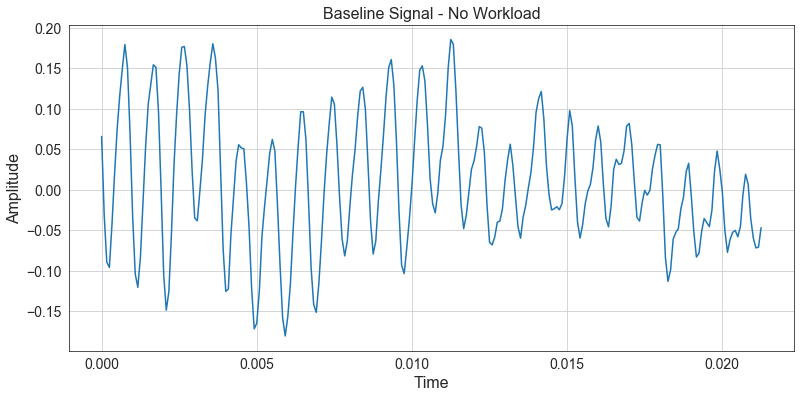

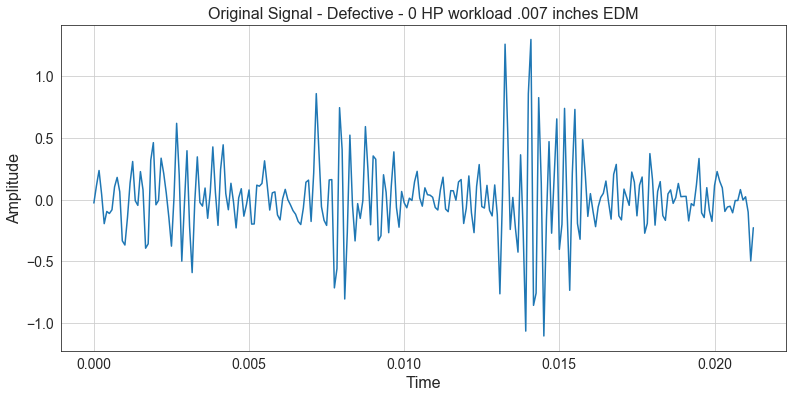

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 22 08:48:45 2020

@author: Paul Scheibal
"""
#
#    This program reads in accelerometer data from multiple files
#    which comes from ball bearing vibration.  The program 
#    classifies the data as follows:
#        
#        0  Baseline Data - 0 HP workload normal
#        1  Baseline Data - 1 HP workload normal
#        2  Baseline Data - 2 HP workload normal
#        3  Baseline Data - 3 HP workload normal
#        4  Faulty Data -   0 HP workload .007 inches EDM 
#        5  Faulty Data -   0 HP workload .014 inches EDM 
#        6  Faulty Data -   0 HP workload .021 inches EDM 
#        7  Faulty Data -   0 HP workload .028 inches EDM 
#        8  Faulty Data -   1 HP workload .007 inches EDM 
#        9  Faulty Data -   1 HP workload .014 inches EDM 
#        10 Faulty Data -   1 HP workload .021 inches EDM 
#        11 Faulty Data -   1 HP workload .028 inches EDM 
#        12 Faulty Data -   2 HP workload .007 inches EDM 
#        13 Faulty Data -   2 HP workload .014 inches EDM 
#        14 Faulty Data -   2 HP workload .021 inches EDM 
#        15 Faulty Data -   2 HP workload .028 inches EDM 
#        16 Faulty Data -   3 HP workload .007 inches EDM 
#        17 Faulty Data -   3 HP workload .014 inches EDM 
#        18 Faulty Data -   3 HP workload .021 inches EDM 
#        19 Faulty Data -   3 HP workload .028 inches EDM 
#        
#        EDM = electromagnetic machining introduced defect
#
#        The accelerometer data is sampled at 12,000 samples per second.
#


import pandas as pd
import numpy as np

import os.path
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl
import pylab as plb
import matplotlib.mlab as mlab
from math import trunc
from scipy.fftpack import fft,fftfreq,ifft,fftshift
from numpy.random import seed
import random
from IPython.core.pylabtools import figsize
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import scipy.io

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras import Sequential

from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import ReLU
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import seaborn as sns
from scipy import signal

sns.set_style('white') 

figsize(13,8)

PATH_DATA = 'C:\\Users\\User\\Documents\\PAUL\\Springboard\\projects\\BearingData\\Data\\'

# this routine plots a segment of sensor data
def plot_segment(x,y,ttl, xlab, ylab):
    figsize(13,6)
    fig, ax = plt.subplots()
    plt.plot(x,y)
    plt.title(ttl, fontsize=16)
    plt.ylabel(ylab, fontsize=16)
    plt.xlabel(xlab, fontsize=16)
    plt.grid(True)
    for tick in ax.get_xticklabels():
        tick.set_fontsize(14)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(14)
    plt.show()

# routine creates n segments of size segment_size
# Each segment is exactly of size segment_size.  The 
# last segment might be smaller than the rest.  If it is,
# it is discarded.
def create_segments(arr,size,label):
    number_of_segments = int(trunc(len(arr)/size))
    features = [[] for x in range(number_of_segments)] 
    labels = [0 for x in range(number_of_segments)]
    for i in range(0,number_of_segments):
        istart = i*size
        iend = (i+1) * size
        segment_arr = list(arr[istart : iend])
        features[i] = segment_arr
        labels[i] = label
    return features, labels


# Reads a datafile of vibration data and puts it into a dataframe       
def get_data(path,filef,prefix,rpm):
    mat = scipy.io.loadmat(path+filef)
    DEcol = prefix + '_DE_time'
    arrDE_time = mat[DEcol]
    valRPM = rpm
    arrDE_time = arrDE_time[:,0]
    df = pd.DataFrame()
    df['DriveEnd_TS'] = arrDE_time
    df['RPM'] = valRPM
    return df

# reads all files and puts them into features and labels
def create_model_inputs(path,flst,fnlst,rpmlst,labellst,segment_size):
    df_temp = pd.DataFrame()
    features_lst = []
    labels_lst = []
    for i in range(0,len(flst)):
        df_temp = get_data(path,flst[i],fnlst[i],rpmlst[i])
        features_temp,labels_temp = create_segments(df_temp.DriveEnd_TS,segment_size,label=labellst[i])
        labels_lst = labels_lst + labels_temp
        features_lst = features_lst + features_temp
    features_arr = np.array(features_lst)
    labels_arr = np.array(labels_lst)
    return features_arr, labels_arr

# hyperparameters to experiment with
segment_size = 256  # size of number of samples in a feature
kernel_size = 16
pool_size = 8 
num_classes = 20
batch_size = 16
num_epochs = 30
test_size = .3
validation_size = .3

# additional paramters
sample_size = segment_size
samples_per_second = 12000
sample_interval = sample_size / samples_per_second
sample_rate = 1 / samples_per_second
freq_high = int(samples_per_second/2)
denominator = 10

# baseline meta data
baseline_file = ['97.mat','98.mat','99.mat','100.mat']
baseline_name = ['X097','X098','X099','X100']
baseline_label = [0,1,2,3]
baseline_rpm = [1797,1772,1750,1730]

# fault meta data
fault_file = ['105.mat','169.mat','209.mat','3001.mat','106.mat','170.mat','210.mat','3002.mat','107.mat','171.mat','211.mat','3003.mat','108.mat','172.mat','212.mat','3004.mat']
fault_name = ['X105','X169','X209','X056','X106','X170','X210','X057','X107','X171','X211','X058','X108','X172','X212','X059']
fault_label = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
fault_rpm = [1797,1797,1797,1797,1772,1772,1772,1772,1750,1750,1750,1750,1730,1730,1730,1730]

# combine baseline and fault metadata into one
input_file = baseline_file + fault_file
input_file_name = baseline_name + fault_name
input_label = baseline_label + fault_label
input_rpm = baseline_rpm + fault_rpm

# read data and create features and labels
feature_input, label_input = create_model_inputs(PATH_DATA,input_file,input_file_name,input_rpm,input_label,segment_size)

t = np.arange(0,sample_interval,sample_rate)

y = feature_input[16,:]
plot_segment(t,y,'Baseline Signal - No Workload','Time','Amplitude')

y = feature_input[6651,:]
plot_segment(t,y,'Original Signal - Defective - 0 HP workload .007 inches EDM','Time','Amplitude')

Define the training and test sets.

In [4]:
# set up data for train/test sets 
train_features,test_features,train_labels,test_labels = train_test_split(feature_input,label_input , test_size=test_size, random_state=61)
train_feature_length = len(train_features)
test_feature_length = len(test_features)
train_signals = train_features
test_signals = test_features
print('\n')
print('\n')
print('Training Set Size ',train_feature_length)
print('Testing Set Size ',test_feature_length)
print('\n')
print('\n')

# reshape features to 3D for input to fit model
train_features = train_features.reshape(train_feature_length,segment_size,1)
test_features = test_features.reshape(test_feature_length,segment_size,1)

# create categorical one hots for train and test labels
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels, num_classes)





Training Set Size  9963
Testing Set Size  4271






Create the One Dimensional CNN model

In [5]:
# CNN 1D model
def create_1d_cnn_model(kernel_size, segment_size, pool_size, num_classes):
    model = Sequential()
    model.add(Conv1D(filters = 64, kernel_size = kernel_size, strides = 1,
                     activation='relu',
                     padding='same',input_shape=(segment_size,1)))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters = 128, kernel_size = kernel_size, strides = 1,
                     activation='relu',
                     padding='same',input_shape=(segment_size,1)))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    print(model.summary())
    return model

# create 1-d CNN model
model = create_1d_cnn_model(kernel_size, segment_size, pool_size,num_classes)
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 256, 64)           1088      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 128)           131200    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                10260     
Total params: 142,548
Trainable params: 142,548
Non-trainable params: 

Train the model and plot results

Train on 6974 samples, validate on 2989 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
6974/6974 [==============================] - 65s 9ms/sample - loss: 1.6056 - acc: 0.3136 - val_loss: 1.1242 - val_acc: 0.4734
Epoch 2/30
6974/6974 [==============================] - 53s 8ms/sample - loss: 0.9795 - acc: 0.5467 - val_loss: 0.9114 - val_acc: 0.6032
Epoch 3/30
6974/6974 [==============================] - 73s 11ms/sample - loss: 0.6915 - acc: 0.6886 - val_loss: 0.5872 - val_acc: 0.7364
Epoch 4/30
6974/6974 [==============================] - 76s 11ms/sample - loss: 0.4870 - acc: 0.7971 - val_loss: 0.4522 - val_acc: 0.8300
Epoch 5/30
6974/6974 [==============================] - 69s 10ms/sample - loss: 0.3805 - acc: 0.8457 - val_loss: 0.4182 - val_acc: 0.8203
Epoch 6/30
6974/6974 [==============================] - 68s 10ms/sample - loss: 0.3288 - acc: 0.8682 - val_loss: 0.3206 - val_acc: 0.8765
Epoch 7/30
6974/6974 [==============================] - 68s 10ms/sample - loss

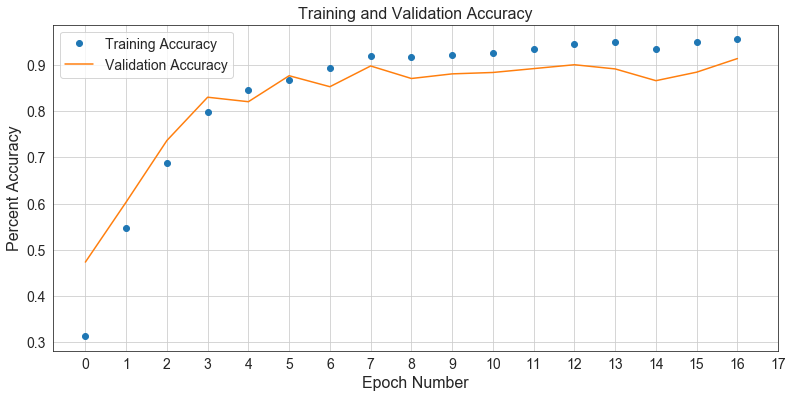

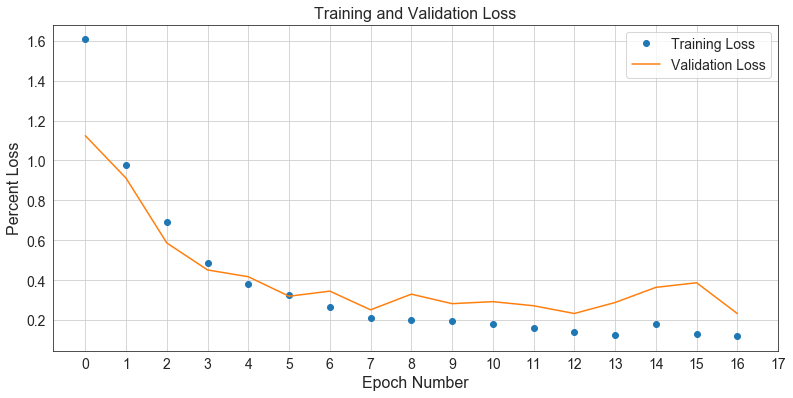

Test Loss: 0.2132760815390433
Test Accuracy: 0.9220323
              precision    recall  f1-score   support

     Class 0       0.98      1.00      0.99       293
     Class 1       0.99      0.89      0.94       581
     Class 2       0.78      0.84      0.81       549
     Class 3       0.86      0.88      0.87       591
     Class 4       0.99      1.00      1.00       125
     Class 5       1.00      1.00      1.00       144
     Class 6       1.00      1.00      1.00       145
     Class 7       0.87      0.95      0.91       146
     Class 8       0.99      1.00      1.00       132
     Class 9       0.99      0.97      0.98       153
    Class 10       0.88      0.99      0.93       135
    Class 11       0.72      0.82      0.76       131
    Class 12       1.00      0.99      1.00       154
    Class 13       0.97      0.99      0.98       146
    Class 14       0.97      0.81      0.88       148
    Class 15       0.94      0.69      0.80       146
    Class 16       1.00   

True

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

class ThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(ThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_acc"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

# This function plots the loss and accuracies of run
# It also prints the classification report and 
# confusion matrix.
def plot_accuracy_and_loss(model,traing_fit,test_features,test_labels_one_hot,test_labels):
    accuracy = training_fit.history['acc']
    val_accuracy = training_fit.history['val_acc']
    loss = training_fit.history['loss']
    val_loss = training_fit.history['val_loss']
    epochs = range(len(accuracy))
    
    fig, ax = plt.subplots()
    ax.grid()
    plt.plot(epochs, accuracy, marker='o',linestyle='none', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy',fontsize=16)
    plt.xlabel('Epoch Number',fontsize=16)
    plt.ylabel('Percent Accuracy',fontsize=16)
    plt.xticks(range(0,len(accuracy)+1,1))
    plt.legend(prop=dict(size=14))
    for tick in ax.get_xticklabels():
        tick.set_fontsize(14)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(14)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.grid()
    plt.plot(epochs, loss, marker='o', linestyle='none', label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss',fontsize=16)
    plt.xlabel('Epoch Number',fontsize=16)
    plt.ylabel('Percent Loss',fontsize=16)
    plt.xticks(range(0,len(accuracy)+1,1))
    plt.legend(prop=dict(size=14))
    for tick in ax.get_xticklabels():
        tick.set_fontsize(14)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(14)
    plt.show()
    
    test_eval = model.evaluate(test_features, test_labels_one_hot, verbose=0)
    print('Test Loss:', test_eval[0])
    print('Test Accuracy:', test_eval[1])
    predicted_classes = model.predict(test_features)
    
    # decide which class won
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    #correct = np.where(predicted_classes==test_labels)[0]
    target_names = ['Class {}'.format(i) for i in range(num_classes)]
    
    # print classification report and confusion matrix
    print(classification_report(test_labels, predicted_classes, target_names=target_names))
    print(confusion_matrix(test_labels, predicted_classes))
    
    return True

#stopping_criterion =[EarlyStopping(monitor='val_acc', baseline=0.91, patience=0)]
custom_callback = ThresholdCallback(threshold=0.91)

# fit model
training_fit = model.fit( train_features,
                          train_labels_one_hot,
                          batch_size=batch_size,
                          epochs=num_epochs,
                          callbacks=[custom_callback],
                          validation_split=validation_size,
                          verbose=1
                        )

# plot statisics on the results of the model run
plot_accuracy_and_loss(model, training_fit, test_features, test_labels_one_hot,test_labels)


As you can see, the results are very good.  Next, features are extracted using feature engineering.

### Feature Engineering FFT and DWT for Sensor Data

Feature Engineering is the creation of features using domain knowledge such as knowledge of the Fast Fourier Transform and Discrete Wavelet Transform to create a set of features as input to the classification model.  The techniques to do this can be found in the following Jupyter Notebooks:

[Feature Engineering with FFT and DWT](https://github.com/paulscheibal/SBDataScienceCert/blob/master/CapstoneP2/Notebooks/SignalAnalysisforFeatureEngineering.ipynb)

[Signal Analysis for Feature Engineering](https://github.com/paulscheibal/SBDataScienceCert/blob/master/CapstoneP2/Notebooks/SignalFeatureEngineeringforBearingData.ipynb)

Let's start by extracting the features from the results of FFT.  Note that the functions for extracting features were written by Ahmet Taspinar and Marcos Duarte.  These functions are made available to anyone who wishes to used them.  The details on how they work can be found at the above two Jupyter Notebooks URLs



In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from scipy.signal import welch
from scipy import signal
from sklearn import preprocessing

#
#  These routines were used from Ahmet Taspinar's github site for extraction
#  of features using fft.
#

# Copied From http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
# Thank you Marcos Duarte.  I copied it from Ahmet's site.

def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.
    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).
    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.
    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 
    See this IPython Notebook [1]_.
    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)
    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)
    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)
    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)
    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)
    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind

def get_values(y_values, T, N, f_s):
    y_values = y_values
    x_values = [(1/f_s) * kk for kk in range(0,len(y_values))]
    return x_values, y_values

def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]
 
def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values
    
def get_first_n_peaks(x,y,no_peaks=10):
    x_, y_ = list(x), list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks], y_[:no_peaks]
    else:
        missing_no_peaks = no_peaks-len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks
#
def get_features(x_values, y_values, mph):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks])
    return peaks_x + peaks_y

#
#  modified for bearing data inputs by Paul Scheibal
#
def extract_fft_features(signals, T, N, f_s, denominator):
    percentile = 5
    list_of_features = []
    for signal_no in range(0, len(signals)):
        signal = signals[signal_no,:]
        
        signal_min = np.nanpercentile(signal, percentile)
        signal_max = np.nanpercentile(signal, 100-percentile)
        mph = signal_min + (signal_max - signal_min)/denominator
        features = []
        features += get_features(*get_psd_values(signal, T, N, f_s), mph)
        features += get_features(*get_fft_values(signal, T, N, f_s), mph)
        features += get_features(*get_autocorr_values(signal, T, N, f_s), mph)
        list_of_features.append(features)
        features = []
    return np.array(list_of_features)
#
#  End of Ahmet Taspinar's functions
#  of features using fft.
#

def create_df_features(arr,col_prefix):
    df = pd.DataFrame()
    for i in range(0,len(arr[0])):
        col = col_prefix+str(i)
        var_lst = []
        for j in range(0,len(arr)):
            var = arr[j][i]
            var_lst.append(var)
        df[col] = var_lst
    return df

def scale_df_features(df):
    # Get column names first
    names = df.columns
    # Create the Scaler object
    scaler = preprocessing.StandardScaler()
    # Fit your data on the scaler object
    scaled_df = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_df, columns=names)
    return scaled_df

# labels for models
y_train = train_labels
y_test = test_labels

X_train_arr = extract_fft_features(train_signals, sample_interval, sample_size, samples_per_second, denominator)
X_test_arr = extract_fft_features(test_signals, sample_interval, sample_size, samples_per_second, denominator)

X_train = create_df_features(X_train_arr,'FFT')
X_test  = create_df_features(X_test_arr,'FFT') 

X_train_fft = X_train
X_test_fft = X_test

X_train_scaled = scale_df_features(X_train)
X_test_scaled = scale_df_features(X_test)

print('\n')
print('\n')
print('Training Set Size ',len(X_train))
print('Testing Set Size ',len(X_test))
print('Number of Features: ',len(X_test.columns))
print('Number of Classes: ',max(y_train)+1)
print('\n')
print('\n')






Training Set Size  9963
Testing Set Size  4271
Number of Features:  60
Number of Classes:  20






Next, run the machine learning classifiers.

In [8]:
def execute_classifiers(X_train, y_train, X_test, y_test, X_train_scaled, X_test_scaled):

    ########################################## Random Forest ##########################################
    
    print('\n')
    print('Random Forests')
    print('\n')
    clf = RandomForestClassifier(n_estimators = 2000, verbose = 1)
    clf.fit(X_train, y_train)
    print("Accuracy on training set is : {}".format(clf.score(X_train, y_train)))
    print("Accuracy on test set is : {}".format(clf.score(X_test, y_test)))
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    ########################################### XGBoost ###############################################
    
    print('\n')
    print('XGB Classifier')
    print('\n')
    
    xgb_cls = XGBClassifier(objective="multi:softprob",num_class=20,random_state=61)
    
    xgb_cls.fit(X_train,y_train)
    print("Accuracy on training set is : {}".format(xgb_cls.score(X_train, y_train)))
    print("Accuracy on test set is : {}".format(xgb_cls.score(X_test, y_test)))
    y_pred = xgb_cls.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    ############################################ GB  ##################################################
    
    print('\n')
    print('GB Classifier')
    print('\n')
    
    gb_cls = GradientBoostingClassifier()
    
    gb_cls.fit(X_train,y_train)
    print("Accuracy on training set is : {}".format(gb_cls.score(X_train, y_train)))
    print("Accuracy on test set is : {}".format(gb_cls.score(X_test, y_test)))
    y_pred = gb_cls.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    ############################################ Knn ##################################################
    
    print('\n')
    print('Knn Classifier')
    print('\n')
    k=11
    knn_cls = KNeighborsClassifier(n_neighbors=k)
    knn_cls.fit(X_train_scaled,y_train)
    print("Accuracy on training set is : {}".format(knn_cls.score(X_train_scaled, y_train)))
    print("Accuracy on test set is : {}".format(knn_cls.score(X_test_scaled, y_test)))
    y_pred = knn_cls.predict(X_test_scaled)
    print(classification_report(y_test, y_pred))
    
    ########################################### SVM Classifier ########################################
    
    print('\n')
    print('SVM Classifier')
    print('\n')
    svm_cls = LinearSVC()
    svm_cls.fit(X_train_scaled,y_train)
    print("Accuracy on training set is : {}".format(svm_cls.score(X_train_scaled, y_train)))
    print("Accuracy on test set is : {}".format(svm_cls.score(X_test_scaled, y_test)))
    y_pred = svm_cls.predict(X_test_scaled)
    print(classification_report(y_test, y_pred))
    
    return True


In [9]:
execute_classifiers(X_train, y_train, X_test, y_test, X_train_scaled, X_test_scaled)



Random Forests




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   26.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy on training set is : 1.0


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   11.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy on test set is : 0.8061343947553267


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   13.7s finished


              precision    recall  f1-score   support

           0       0.95      0.93      0.94       293
           1       0.83      0.79      0.81       581
           2       0.57      0.60      0.58       549
           3       0.73      0.73      0.73       591
           4       0.88      0.89      0.88       125
           5       0.91      0.89      0.90       144
           6       0.95      0.85      0.89       145
           7       0.83      0.91      0.87       146
           8       0.78      0.79      0.78       132
           9       0.91      0.92      0.92       153
          10       0.72      0.86      0.78       135
          11       0.73      0.73      0.73       131
          12       0.90      0.84      0.87       154
          13       0.92      0.92      0.92       146
          14       0.85      0.76      0.80       148
          15       0.81      0.66      0.73       146
          16       0.93      0.99      0.96       139
          17       0.98    

True

Next, extract the features for the Discrete Wavelet Transform

In [10]:
import pywt
from collections import defaultdict, Counter

#
#  These routines were used from Ahmet Taspinar's github site for extraction
#  of features using dwt.
#
# Copyright (c) 2016 by Ahmet Taspinar (taspinar@gmail.com)
#

def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

#  Copyright (c) 2016 by Ahmet Taspinar (taspinar@gmail.com)
def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

#  Copyright (c) 2016 by Ahmet Taspinar (taspinar@gmail.com)
def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

#  Copyright (c) 2016 by Ahmet Taspinar (taspinar@gmail.com)
def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics
#
# modified by Paul Scheibal for bearing data input
#
def extract_dwt_features(signals, waveletname,level=-1):
    all_features = []
    for signal_no in range(0, len(signals)):
        signal = signals[signal_no]
        features = []
        if level == -1 :
            list_coeff = pywt.wavedec(signal, waveletname)
        else:
            list_coeff = pywt.wavedec(signal, waveletname,level)
        for coeff in list_coeff:
            features += get_features(coeff)
        all_features.append(features)
    X = np.array(all_features)
    return X

#
#  End of Ahmet Taspinar's functions
#  of features using dwt.
#

waveletname = 'sym2' # worked best in testing
level=-1 # do all levels

# extract dwt features
X_train_arr = extract_dwt_features(train_signals,waveletname,level)
X_test_arr = extract_dwt_features(test_signals,waveletname,level)

# create dateframes
X_train = create_df_features(X_train_arr,'DWT')
X_test  = create_df_features(X_test_arr,'DWT')
                             
X_train_dwt = X_train
X_test_dwt = X_test

X_train_scaled = scale_df_features(X_train)
X_test_scaled = scale_df_features(X_test)
                             
print('\n')
print('\n')
print('Training Set Size ',len(X_train))
print('Testing Set Size ',len(X_test))
print('Number of Features: ',len(X_test.columns))
print('Number of Classes: ',max(y_test)+1)
print('\n')
print('\n')





Training Set Size  9963
Testing Set Size  4271
Number of Features:  84
Number of Classes:  20






Execute classifiers for DWT Engineered Features

In [11]:
execute_classifiers(X_train, y_train, X_test, y_test, X_train_scaled, X_test_scaled)



Random Forests




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  6.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   22.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy on training set is : 1.0


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    8.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy on test set is : 0.7981737298056661


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   10.5s finished


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       293
           1       0.92      0.96      0.94       581
           2       0.67      0.71      0.69       549
           3       0.79      0.71      0.75       591
           4       0.97      0.93      0.95       125
           5       0.99      0.99      0.99       144
           6       0.87      0.90      0.89       145
           7       0.77      0.77      0.77       146
           8       0.60      0.69      0.64       132
           9       0.92      0.87      0.90       153
          10       0.69      0.76      0.73       135
          11       0.58      0.63      0.60       131
          12       0.68      0.55      0.60       154
          13       0.87      0.92      0.89       146
          14       0.66      0.51      0.57       148
          15       0.72      0.60      0.66       146
          16       0.72      0.80      0.76       139
          17       0.99    

True

Combine the Engineered features from FFT and DWT into one set of features and rerun.

In [12]:
X_train = pd.concat([X_train_fft,X_train_dwt],axis=1)
X_test = pd.concat([X_test_fft,X_test_dwt],axis=1)

X_train_scaled = scale_df_features(X_train)
X_test_scaled = scale_df_features(X_test)

print('\n')
print('\n')
print('Training Set Size ',len(X_train))
print('Testing Set Size ',len(X_test))
print('Number of Features: ',len(X_test.columns))
print('Number of Classes: ',max(y_test)+1)
print('\n')
print('\n')






Training Set Size  9963
Testing Set Size  4271
Number of Features:  144
Number of Classes:  20






In [13]:
execute_classifiers(X_train, y_train, X_test, y_test, X_train_scaled, X_test_scaled)



Random Forests




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  8.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   21.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy on training set is : 1.0


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    9.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy on test set is : 0.8536642472488879


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   10.6s finished


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       293
           1       0.93      0.97      0.95       581
           2       0.69      0.74      0.72       549
           3       0.81      0.73      0.77       591
           4       0.98      0.98      0.98       125
           5       0.99      0.99      0.99       144
           6       0.97      0.96      0.96       145
           7       0.81      0.84      0.82       146
           8       0.81      0.80      0.80       132
           9       0.94      0.90      0.92       153
          10       0.76      0.86      0.81       135
          11       0.65      0.67      0.66       131
          12       0.85      0.82      0.84       154
          13       0.90      0.94      0.92       146
          14       0.82      0.70      0.75       148
          15       0.75      0.68      0.71       146
          16       0.93      0.98      0.95       139
          17       0.99    

True

### Results

The results of the machine learning runs were positive.  The contemporary appoarch using 1-D CNN scored the best accuracy but the combined features engineered from FFT and DWT using XGBoost and Gradient Boosting had good performance numbers.

![title](img/mlresults.GIF)
